In [1]:
!pip install -q scikit-learn geopy shap sweetviz rapidfuzz joblib
import pandas as pd, numpy as np, joblib, json, re, math, shap, sweetviz
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.9 MB/s eta 0:00:00


In [2]:
#load data
train = pd.read_csv("naf_analyzer_train.csv")
val   = pd.read_csv("naf_analyzer_val.csv")
test  = pd.read_csv("naf_analyzer_test.csv")

print(train.shape, val.shape, test.shape)
train.head()


(33, 9) (33, 9) (8, 9)


,id,academy,track_certified,high_school,company_internship,company_job,city,state,target
0,1,CTE Industry Scholars Program,NaN,James Madison High School,NAF,Asphalt Green,New York City Metropolitan Area,New York,1
1,2,NAF Academy of Information Technology,NaN,James Madison High School,NaN,NaN,Dallas,Texas,1
2,3,Academy of Finance,NaN,Emmett J Conrad High School,NaN,NaN,Dallas,Texas,1
3,4,Academy of Finance and Information Technology,Yes,Southwest Miami Senior High School,Zoo Miami,NaN,NaN,NaN,1
4,5,Academy of Engineering,NaN,Hillcrest High School,"The Fab Lab at WorkChops, Verizon, Thaddeus Re...","Thaddeus Resouce Center, Target",Dallas,Texas,1


In [3]:
import json

# read JSON
with open('high_schools.json', 'r') as f:
    HIGH_SCHOOLS_JSON = json.load(f)

with open('partner_companies.json', 'r') as f:
    PARTNERED_COMPANIES_JSON = json.load(f)

with open('academies.json', 'r') as f:
    ACADEMY_LOCATIONS_JSON = json.load(f)

HIGH_SCHOOLS      = { entry['name'].lower() for entry in HIGH_SCHOOLS_JSON }
PARTNER_COMPANIES = { entry['name'].lower() for entry in PARTNERED_COMPANIES_JSON }
ACADEMIES         = pd.DataFrame(ACADEMY_LOCATIONS_JSON)

print(len(HIGH_SCHOOLS), "high schools loaded")
print(len(PARTNER_COMPANIES), "partner companies loaded")
print(ACADEMIES.shape, "academy locations loaded")


327 high schools loaded
26 partner companies loaded
(131, 4) academy locations loaded


In [4]:
# geocoding
geocoder = Nominatim(user_agent="naf_analyzer")
coords_cache = {}

def latlon(city, state):
    key = f"{city},{state}".lower()
    if key in coords_cache:
        return coords_cache[key]
    try:
        loc = geocoder.geocode(f"{city}, {state}", timeout=10)
        coords_cache[key] = (loc.latitude, loc.longitude) if loc else (np.nan, np.nan)
    except Exception:
        coords_cache[key] = (np.nan, np.nan)
    return coords_cache[key]



In [5]:
#business rules
class NAFEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def _fuzzy_in(self, value, space):
        """fuzzy 90/100 match to handle typos"""
        if pd.isna(value): return 0
        match, score, _ = process.extractOne(
            str(value).lower(), space, scorer=fuzz.partial_ratio
        )
        return int(score >= 90)

    def _nearest_academy(self, row):
        if pd.isna(row['lat']) or pd.isna(row['lon']):
            return np.nan
        # vectorised haversine by geodesic (must change for larger datasets)
        dists = ACADEMIES.apply(
            lambda r: geodesic((row['lat'],row['lon']), (r.lat,r.lon)).km, axis=1
        )
        return dists.min()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        #clean
        for col in ['academy','high_school','Company_internship','company_job','city','state']:
            if col in df.columns:
                df[col] = (df[col]
                           .astype(str)
                           .str.strip()
                           .str.replace(r'\s+', ' ', regex=True)
                           .str.lower()
                           .replace({'nan':np.nan, '':np.nan}))

        #indicators
        df['rule_definite'] = (
            df['academy'].notna() |
            df['track_certified'].isin(['yes','true','1'])
        ).astype(int)

        #high-school/company matches
        df['hs_match']   = df['high_school'].apply(lambda v: self._fuzzy_in(v, HIGH_SCHOOLS))
        df['intern_cmp'] = df['Company_internship'].apply(lambda v: self._fuzzy_in(v, PARTNER_COMPANIES))
        df['job_cmp']    = df['company_job'].apply(lambda v: self._fuzzy_in(v, PARTNER_COMPANIES))

        #geolocation
        coords = df.apply(lambda r: latlon(r['city'], r['state']), axis=1)
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
        df['dist_km'] = df.apply(self._nearest_academy, axis=1)
        df['prox_strong'] = (df['dist_km'] < 80).astype(int)
        df['prox_weak']   = ((df['dist_km'] >= 80) & (df['dist_km'] <= 160)).astype(int)

        #binary cleanup
        df['track_certified_flag'] = df['track_certified'].isin(['yes','true','1']).astype(int)
        df['has_academy']          = df['academy'].notna().astype(int)

        # keep only numeric engineered columns + rule flag
        return df[[
            'rule_definite','has_academy','track_certified_flag',
            'hs_match','intern_cmp','job_cmp',
            'prox_strong','prox_weak'
        ]].fillna(0).astype(int)


In [6]:
#ONE-OFF column normaliser

_EXPECTED = [
    "academy", "track_certified", "high_school",
    "Company_internship", "company_job", "city", "state"
]

_RENAME = {
    "company_internship": "Company_internship",
    "company internship": "Company_internship",
    "internship_company": "Company_internship",
    "companyJob": "company_job",
    "company job": "company_job",
    "highschool": "high_school",
    "hs": "high_school"
}

def normalise_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    #clean white-space and lower-case
    df.columns = [c.strip().lower() for c in df.columns]

    #renames
    df.rename(columns=_RENAME, inplace=True)

    #capitalise final canonical names
    if "company_internship" in df.columns:
        df.rename(columns={"company_internship": "Company_internship"}, inplace=True)

    # add columns that are still missing so pipeline never fails
    for col in _EXPECTED:
        if col not in df.columns:
            df[col] = np.nan

    return df


In [7]:
#build, fit, evaluate
pipe = Pipeline([
    ('eng', NAFEngineer()),
    ('clf', LogisticRegression(class_weight='balanced',
                               max_iter=300,
                               random_state=42))
])

#train
train_fixed = normalise_columns(train)
y_train = train_fixed['target']
X_train = train_fixed.drop(columns='target')
pipe.fit(X_train, y_train)

#validation
val_fixed = normalise_columns(val)
y_val  = val_fixed['target']
X_val  = val_fixed.drop(columns='target')

y_pred = pipe.predict(X_val)
y_prob = pipe.predict_proba(X_val)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, y_prob))


              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.93      0.78      0.85        18

    accuracy                           0.85        33
   macro avg       0.86      0.86      0.85        33
weighted avg       0.86      0.85      0.85        33

AUC: 0.9


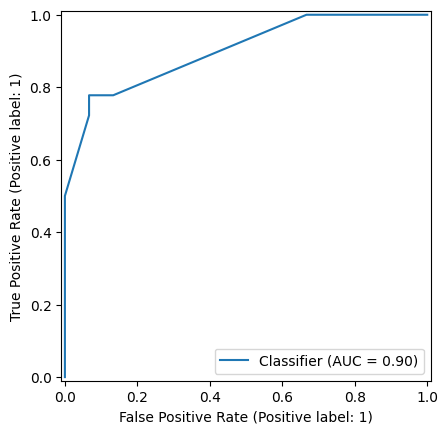

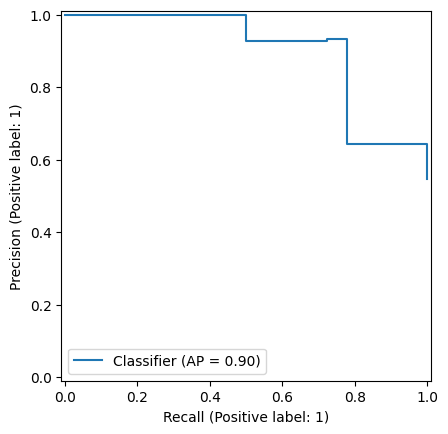

Best F1 threshold: 0.571


In [8]:
#ROC & PR curves
RocCurveDisplay.from_predictions(y_val, y_prob); plt.show()
PrecisionRecallDisplay.from_predictions(y_val, y_prob); plt.show()

# choose threshold to maximises F1
prec, rec, thr = precision_recall_curve(y_val, y_prob)
f1 = 2*(prec*rec)/(prec+rec+1e-9)
best_thr = thr[np.argmax(f1)]
print("Best F1 threshold:", best_thr.round(3))


In [9]:
#inspect coefficients

# grab one row, pass through the SAME normaliser used everywhere else
sample = normalise_columns(train.head(1))

# transform to get the post-engineering feature order
feat_cols = pipe.named_steps['eng'].transform(sample).columns

# model coefficients
coef = pipe.named_steps['clf'].coef_[0]

coef_df = (
    pd.DataFrame({"feature": feat_cols, "beta": coef})
      .sort_values("beta", ascending=False)
      .reset_index(drop=True)
)

coef_df


,feature,beta
0,hs_match,1.405408
1,rule_definite,0.798730
2,has_academy,0.798730
3,prox_strong,0.788605
4,prox_weak,0.392709
5,intern_cmp,0.361628
6,track_certified_flag,0.000000
7,job_cmp,0.000000


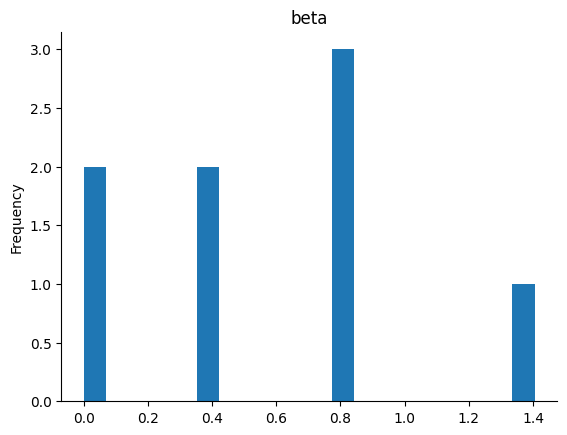

In [ ]:
# @title beta

from matplotlib import pyplot as plt
coef_df['beta'].plot(kind='hist', bins=20, title='beta')
plt.gca().spines[['top', 'right',]].set_visible(False)

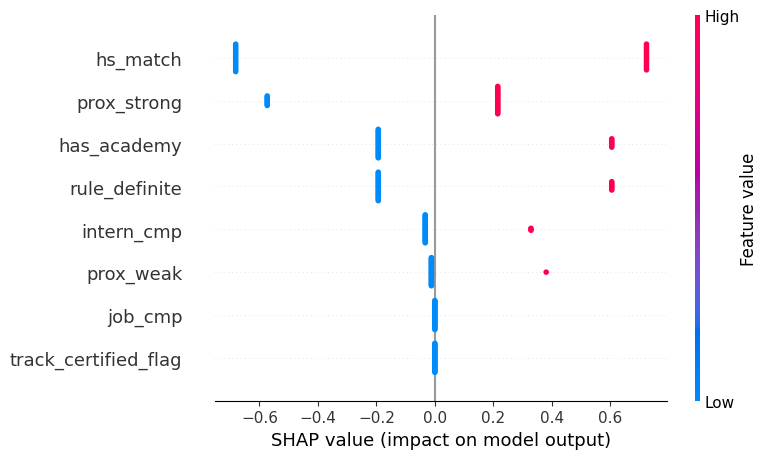

In [10]:
#SHAP check
import shap
shap.initjs()                     # for colab plots

#engineered matrices on same schema
X_train_eng = pipe.named_steps['eng'].transform(
                 normalise_columns(train).drop(columns='target')
              )
X_val_eng   = pipe.named_steps['eng'].transform(
                 normalise_columns(val).drop(columns='target')
              )

#build linear explainer with new masker API
masker    = shap.maskers.Independent(X_train_eng)
explainer = shap.LinearExplainer(pipe.named_steps['clf'], masker)

#generate SHAP values on validation set
shap_values = explainer(X_val_eng)

#summary
shap.summary_plot(shap_values, X_val_eng, feature_names=X_val_eng.columns)


In [11]:
#final test
import warnings
from sklearn.metrics import classification_report, roc_auc_score

warnings.filterwarnings("ignore", category=FutureWarning)   # hides the replace() warning

#check: schema matches what NAFEngineer expects
test_fixed = normalise_columns(test)

#separate features / target
y_test = test_fixed['target']
X_test = test_fixed.drop(columns='target')

#evaluate
print(classification_report(y_test, pipe.predict(X_test)))
print("Final test AUC:", roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.00      0.00      0.00         0

    accuracy                           0.88         8
   macro avg       0.50      0.44      0.47         8
weighted avg       1.00      0.88      0.93         8

Final test AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: 

In [12]:
#wrap into helper
def naf_infer(raw_profile: pd.DataFrame, thr=best_thr):
    features = pipe.named_steps['eng'].transform(raw_profile)
    if features['rule_definite'].iloc[0] == 1:      # academy OR track certified
        return 1, 1.0                               # forced 100 % confidence
    prob = pipe.named_steps['clf'].predict_proba(features)[:,1][0]
    return int(prob >= thr), prob


In [14]:
#feature weightages
import pandas as pd
import numpy as np

features = normalise_columns(train.head(1).copy())      # <-- your helper
X_eng = pipe.named_steps['eng'].transform(features)      # engineered features

coefs = pipe.named_steps['clf'].coef_.flatten()

weights = (
    pd.DataFrame({"feature": X_eng.columns, "weight": coefs})
      .sort_values("weight", ascending=False)
      .reset_index(drop=True)
)

print("Logistic‑regression weights (β):")
display(weights)


Logistic‑regression weights (β):


,feature,weight
0,hs_match,1.405408
1,rule_definite,0.798730
2,has_academy,0.798730
3,prox_strong,0.788605
4,prox_weak,0.392709
5,intern_cmp,0.361628
6,track_certified_flag,0.000000
7,job_cmp,0.000000
